# Train a model with _Bike Rental Data_ using XGBoost

This section will work with XGBoost as a local installation to the instance.

## Training _log1p(count)_ onto Dataset

**Kernel used:** Conda with TensorFlow Python 3.6.5 for Amazon Elastic Instance *(conda_amazonei_tensorflow_p36)*

### First update *conda* and *pip* to latest version

In [ ]:
!conda update -n base conda
!pip install --upgrade pip

### Ensure required packages are installed

In [1]:
!conda list nb_conda
!conda list numpy
!conda list pandas
!conda list pip
!conda list python
!conda list matplotlib

# packages in environment at /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36:
#
# Name                    Version                   Build  Channel
nb_conda                  2.2.1                    py36_2    conda-forge
nb_conda_kernels          2.2.2                    py36_0    conda-forge
# packages in environment at /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36:
#
# Name                    Version                   Build  Channel
numpy                     1.14.3           py36hcd700cb_1  
numpy                     1.17.4                    <pip>
numpy-base                1.14.3           py36h9be14a7_1  
numpydoc                  0.8.0                    py36_0  
# packages in environment at /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36:
#
# Name                    Version                   Build  Channel
pandas                    0.24.2           py36he6710b0_0  
# packages in environment at /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36:
#
# Name     

### Major Library Versions Used

| Library | Version |
|---------|:--------|
| nb_conda | 2.2.1 |
| matplotlib | 3.0.3 |
| numpy | 1.17.4 |
| pandas | 0.24.2 |
| pip | 20.2 |
| python | 3.6.5 |
| xgboost | 0.90 |

## Install xgboost

In [3]:
!conda install -y -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python-3.6.7               |    h381d211_1004        34.5 MB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    tk-8.6.10                  |       hed695b0_0         3.2 MB  conda-forge
    xgboost-0.90               |   py36he1b5a44_4          11 KB  conda-forge
    grpcio-1.23.0              |   py36he9ae1f9_0         1.1 MB  conda-forge
    curl-7.68.0                |       hf8cf82a_0         137 KB  conda-forge
    pykerberos-1.2.1           |   py3

In [4]:
## Import Libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
# XGBoost
import xgboost as xgb

## Load Data Files from Data Preparation Phase

In [6]:
column_list_file = 'bikeTrain_column_listv2.txt'
train_file = 'bikeTrainingv2.csv'
validation_file ='bikeValidationv2.csv'
test_file ='bikeTestv2.csv'

In [7]:
columns = '' # setup columns variable as empty string
with open(column_list_file,'r') as f:
    columns = f.read().split(',') # columns read from text file containing CSV

In [8]:
columns # data check

['count',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'month',
 'day',
 'dayofweek',
 'hour']

### Specify Column Names as the File Does Not Have Header

In [9]:
df_train = pd.read_csv(train_file, names=columns)
df_validation = pd.read_csv(validation_file,names=columns)

In [10]:
df_train.head()

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour
0,2.772589,3,0,1,1,28.70,33.335,74,8.9981,2011,7,6,2,1
1,3.401197,1,0,1,1,17.22,21.210,77,15.0013,2012,3,8,3,5
2,4.700480,1,0,1,1,13.12,14.395,49,27.9993,2012,2,2,3,22
3,4.110874,1,0,1,1,9.84,12.880,70,7.0015,2012,1,5,3,23
4,5.517453,1,0,1,1,14.76,17.425,27,15.0013,2011,3,8,1,17


In [11]:
df_validation.head() # data check

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour
0,6.336826,2,0,1,1,28.70,31.820,24,19.9995,2011,6,3,4,18
1,5.638355,4,0,1,2,20.50,24.240,63,16.9979,2012,12,4,1,21
2,5.484797,4,0,1,1,24.60,31.060,53,23.9994,2011,11,14,0,20
3,4.158883,1,0,1,1,15.58,19.695,82,26.0027,2011,2,2,2,14
4,5.720312,3,0,0,1,30.34,34.090,60,15.0013,2011,7,17,6,10


### Separating Features and Targets for Training and Validation
This is in preparation for use in XGBoost's regressor
*Note: Remember that Python indices start at 0*

In [12]:
x_train = df_train.iloc[:,1:] # Features: Seconds [1] Column to the end
y_train = df_train.iloc[:,0].ravel() # Target is the first column [0]th

x_validation = df_validation.iloc[:,1:] # Features: Seconds [1] Column to the end
y_validation = df_validation.iloc[:,0].ravel() # Target is the first column [0]th

## Set Up XGBoost Regressor

Below cells will set up the training instance, set the hyperparameters, and then fit the model to the training data.

Find Distributed (Deep) Machine Learning Community's XGBoost Training Parameter Reference [here](https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst)

In this project, I updated the following parameters:
```reg:squarederror``` as ```reg:linear``` is deprecated.

Additionally, I am to add my tuning to the _XGBoost_ Regressor.

### Create Regressor

In [13]:
# Create regressor
# XGBoost Training Parameters Reference:
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
# Limited the depth to 5 vice 6.
# n_estimators helps tune the number of Decision Trees in XGBoost

regressor = xgb.XGBRegressor(max_depth=5, n_estimators=200, objective='reg:squarederror')
# n_estimators at 150, 200 over to 250 results in little additional log loss reduction

In [14]:
regressor # display hyperparameters. This is my habit to ensure my settings are correct \\
# before I run a regressor. Note: This will display at the end of the training model process, as well.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [15]:
regressor.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_validation, y_validation)])

[0]	validation_0-rmse:3.90472	validation_1-rmse:3.91357
[1]	validation_0-rmse:3.5249	validation_1-rmse:3.53504
[2]	validation_0-rmse:3.18387	validation_1-rmse:3.19418
[3]	validation_0-rmse:2.87664	validation_1-rmse:2.88818
[4]	validation_0-rmse:2.60149	validation_1-rmse:2.61376
[5]	validation_0-rmse:2.35456	validation_1-rmse:2.36767
[6]	validation_0-rmse:2.13221	validation_1-rmse:2.14598
[7]	validation_0-rmse:1.93402	validation_1-rmse:1.94906
[8]	validation_0-rmse:1.75471	validation_1-rmse:1.77047
[9]	validation_0-rmse:1.59361	validation_1-rmse:1.61017
[10]	validation_0-rmse:1.45068	validation_1-rmse:1.46871
[11]	validation_0-rmse:1.3224	validation_1-rmse:1.34146
[12]	validation_0-rmse:1.20789	validation_1-rmse:1.22784
[13]	validation_0-rmse:1.10591	validation_1-rmse:1.12706
[14]	validation_0-rmse:1.01452	validation_1-rmse:1.03682
[15]	validation_0-rmse:0.928974	validation_1-rmse:0.952268
[16]	validation_0-rmse:0.853387	validation_1-rmse:0.877622
[17]	validation_0-rmse:0.789737	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [19]:
df_train['count'].describe()

count    7620.000000
mean        4.591056
std         1.412984
min         0.693147
25%         3.784190
50%         4.976734
75%         5.645447
max         6.885510
Name: count, dtype: float64

In [16]:
eval_result = regressor.evals_result()

In [17]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

In [20]:
print(training_rounds) # check

range(0, 200)


## Plot the Training vs. Validation Errors

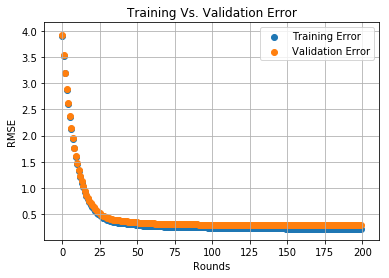

In [21]:
plt.scatter(x=training_rounds, y=eval_result['validation_0']['rmse'], label='Training Error')
plt.scatter(x=training_rounds, y=eval_result['validation_1']['rmse'], label='Validation Error')
plt.grid(True)
plt.xlabel('Rounds')
plt.ylabel('RMSE')
plt.title('Training Vs. Validation Error')
plt.legend()
plt.show()

### XGBoost Feature Importance
By default, the graph displays as a horiztonal bar with counters.

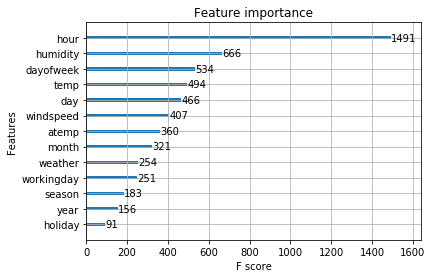

In [25]:
xgb.plot_importance(regressor)
plt.show()

### Verify Quality using Validation Dataset

In [26]:
df = pd.read_csv(validation_file,names=columns)
# compare actual vs. predicted performance with dataset not seen by the model

In [27]:
df.head() # data check

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour
0,6.336826,2,0,1,1,28.70,31.820,24,19.9995,2011,6,3,4,18
1,5.638355,4,0,1,2,20.50,24.240,63,16.9979,2012,12,4,1,21
2,5.484797,4,0,1,1,24.60,31.060,53,23.9994,2011,11,14,0,20
3,4.158883,1,0,1,1,15.58,19.695,82,26.0027,2011,2,2,2,14
4,5.720312,3,0,0,1,30.34,34.090,60,15.0013,2011,7,17,6,10


In [28]:
df.shape # display a tuple that represents Dataframe's dimensionality (columns, rows, depth, etc.)

(3266, 14)

In [29]:
x_test = df.iloc[:,1:]
print(x_test[:5])

   season  holiday  workingday  weather   temp   atemp  humidity  windspeed  \
0       2        0           1        1  28.70  31.820        24    19.9995   
1       4        0           1        2  20.50  24.240        63    16.9979   
2       4        0           1        1  24.60  31.060        53    23.9994   
3       1        0           1        1  15.58  19.695        82    26.0027   
4       3        0           0        1  30.34  34.090        60    15.0013   

   year  month  day  dayofweek  hour  
0  2011      6    3          4    18  
1  2012     12    4          1    21  
2  2011     11   14          0    20  
3  2011      2    2          2    14  
4  2011      7   17          6    10  


In [30]:
result = regressor.predict(x_test)

In [31]:
result[:5]

array([6.1957946, 5.5036707, 5.6446824, 4.099272 , 5.692396 ],
      dtype=float32)

In [33]:
df['count_predicted'] = result

In [34]:
df.head() # new column at the end

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour,count_predicted
0,6.336826,2,0,1,1,28.70,31.820,24,19.9995,2011,6,3,4,18,6.195795
1,5.638355,4,0,1,2,20.50,24.240,63,16.9979,2012,12,4,1,21,5.503671
2,5.484797,4,0,1,1,24.60,31.060,53,23.9994,2011,11,14,0,20,5.644682
3,4.158883,1,0,1,1,15.58,19.695,82,26.0027,2011,2,2,2,14,4.099272
4,5.720312,3,0,0,1,30.34,34.090,60,15.0013,2011,7,17,6,10,5.692396


### Negative Values can appear in predictions
Displayed through _pandas_ DataFrame Describe function

_Generate descriptive statistics_

### Finding All Negative Values for Zeroizing
Sometimes, regressors predict values that do not match the problem's context.

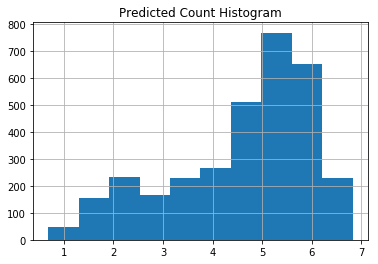

In [35]:
df['count_predicted'].hist()
plt.title('Predicted Count Histogram')
plt.show()
# There are values below 0

In [36]:
df[df['count_predicted'] < 0]

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour,count_predicted


Note: There are no values below 0.

### Adjust the Count to Just Data Points

In [40]:
def adjust_count(x):
    if x < 0:
        return 0
    else:
        return x

In [41]:
df['count_predicted'] = df['count_predicted'].map(adjust_count)

In [42]:
df[df['count_predicted'] < 0] # double-check

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour,count_predicted


In [43]:
df['count'] = df['count'].map(np.expm1)
df['count_predicted'] = df['count_predicted'].map(np.expm1)

## Plot Actual vs. Predicted

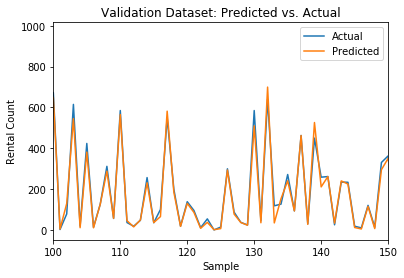

In [44]:
plt.plot(df['count'], label='Actual')
plt.plot(df['count_predicted'], label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Rental Count')
plt.xlim([100,150])
plt.title('Validation Dataset: Predicted vs. Actual')
plt.legend()
plt.show()

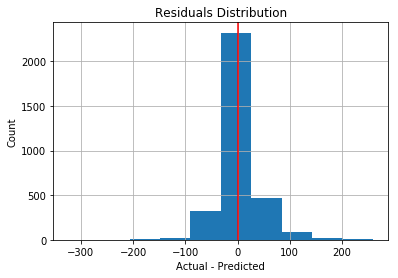

In [45]:
# Over prediction and Under Prediction needs to be balanced
# Training Data Residuals
residuals = (df['count'] - df['count_predicted'])

plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

In [46]:
value_counts = (residuals > 0).value_counts(sort=False)
print(' Under Estimation: {0:0.2f}'.format(value_counts[True]/len(residuals)))
print(' Over  Estimation: {0:0.2f}'.format(value_counts[False]/len(residuals)))

 Under Estimation: 0.54
 Over  Estimation: 0.46


### Print Metrics of the Model

In [50]:
# Current Model's RMSE
print("Model's RMSE: {0:0.2f}".format(mean_squared_error(df['count'],df['count_predicted'])**.5))

Model's RMSE: 40.41


In [51]:
# RMSlE - Root Mean Squared Log Error
# RMSLE Metric is used by Kaggle

# RMSE Cost Function - Magnitude of difference matters

# RMSLE cost function - "Only Percentage difference matters"

# Reference:Katerina Malahova, Khor SoonHin 
# https://www.slideshare.net/KhorSoonHin/rmsle-cost-function
def compute_rmsle(y_true, y_pred):
    if type(y_true) != np.ndarray:
        y_true = np.array(y_true)
        
    if type(y_pred) != np.ndarray:
        y_pred = np.array(y_pred)
     
    return(np.average((np.log1p(y_pred) - np.log1p(y_true))**2)**.5)

In [53]:
print('RMSE: {0:.2f}'.format(compute_rmsle(df['count'], df['count_predicted'])))

RMSE: 0.29


## Prepare Data for Kaggle Submission

In [54]:
df_test = pd.read_csv(test_file,parse_dates=['datetime'])

In [55]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,3,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,4


In [56]:
x_test =  df_test.iloc[:,1:] # Exclude datetime for prediction

In [57]:
x_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,3,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,4


In [58]:
result = regressor.predict(x_test)

In [59]:
result[:5]

array([2.7636895, 1.9933898, 1.5712538, 1.2260903, 1.1937907],
      dtype=float32)

In [60]:
np.expm1(result)

array([ 14.858244 ,   6.3403745,   3.8126783, ..., 129.77707  ,
       103.49721  ,  55.03498  ], dtype=float32)

In [ ]:
df_test.head() # data checck

In [ ]:
df_test[df_test["count"] < 0]

In [ ]:
df_test["count"] = df_test["count"].map(adjust_count)

In [ ]:
df_test[['datetime','count']].to_csv('predicted_count.csv',index=False)